In [37]:
import matplotlib.pyplot as plt 
import numpy as np 
from PIL import Image 

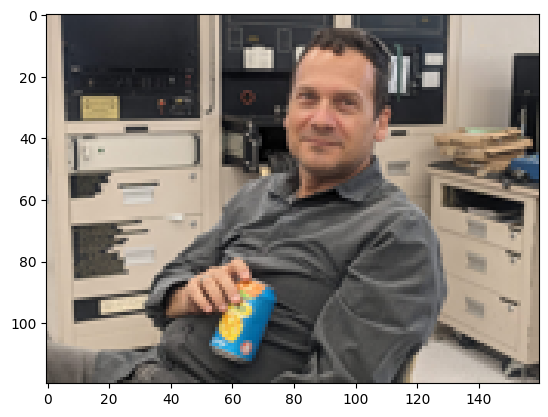

In [38]:
image_path = 'C:\\Users\\bkand\\Downloads\\tanya-images\\ashush_body.jpeg'
image_path = 'C:\\Users\\bkand\\Downloads\\shilon.jpeg'

with Image.open(image_path) as im: 
    w, h = im.size; ratio = w/h
    im = im.resize((int(ratio*120), 120))
    img = np.asarray(im)
plt.imshow(img)

In [4]:
# Bayers dithering levels
M2 = (1/4) * np.array([
    0, 2, 
    3, 1
]).reshape(2, 2)

M4 = (1/16) * np.array([
    0, 8, 2, 10, 
    12, 4, 14, 6, 
    3, 11, 1, 9, 
    15, 7, 13, 5
]).reshape(4, 4)

M8 = (1/64) * np.array([
    0, 32, 8, 40, 2, 32, 10, 42, 
    48, 16, 56, 24, 50, 18, 58, 26, 
    12, 44, 4, 26, 14, 46, 6, 38, 
    60, 28, 52, 20, 62, 30, 54, 22, 
    3, 35, 11, 43, 1, 33, 9, 41, 
    51, 19, 59, 27, 49, 17, 57, 25, 
    15, 47, 7, 39, 13, 45, 5, 37, 
    63, 31, 55, 23, 61, 29, 53, 21
]).reshape(8, 8)

color_palette = np.array([ 
    [0 ,0 ,0], # black 
    [255, 0, 0], # red
    [0, 255, 0], # green
    [255, 255, 0], # yellow
    [0, 0, 255], # blue
    [255, 0, 255], # magenta
    [255, 255, 255], # white
    [150, 75, 0], # brown
    [0, 127, 127], # cyan50

    [127, 0, 0], # red50
    [0, 127, 0], # green50
    [127, 127, 0], # yellow50
    [0, 0, 127], # blue50
    [127, 0, 127], # magenta50
    [192, 192, 192] # gray75
])

color_palette_names = [ 
    'Black', 'Red', 'Green', 'Yellow', 'Blue', 'Magenta', 'White', 'Brown', 'Cyan50', 'Red50', 'Green50', 'Yellow50', 'Blue50', 'Magenta50', 'Gray75'
]

def nearest_color_palette(c): 
    # quantizing to 16 colors
    c_hat = np.clip((255 * c), 0, 255).astype('uint8')
    err = ((color_palette - c_hat)**2).sum(axis=1)
    idx = np.argmin(err) # the index of minimum error
    return color_palette_names[idx], color_palette[idx]

n = 8 # color num
w, h = img.shape[:2]
r = 1 # 255/n  # spread 

new_img = np.zeros(img.shape)
new_img_img = ''
for x in range(w):
    for y in range(h):
        pixel_name, pixel = nearest_color_palette( (1/255)*img[x, y] + r * M8[x%8, y%8] -.5)
        new_img[x, y] = pixel
        new_img_img += f'Dot {pixel_name}, {x}, {y}\n'

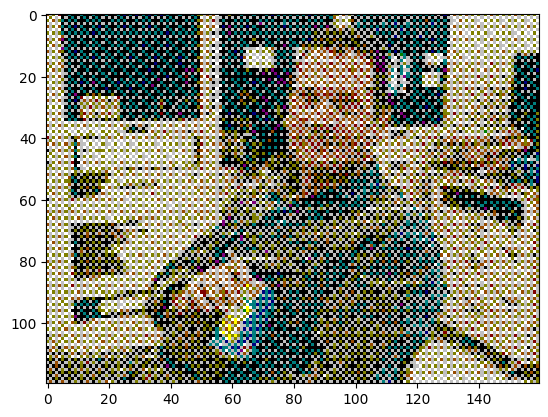

In [5]:
plt.imshow(new_img.astype('uint8'))

In [6]:
# convert to Video Generator Format (file called face.img)

with open('face.img', '+a') as face_img: 
    face_img.write(new_img_img)

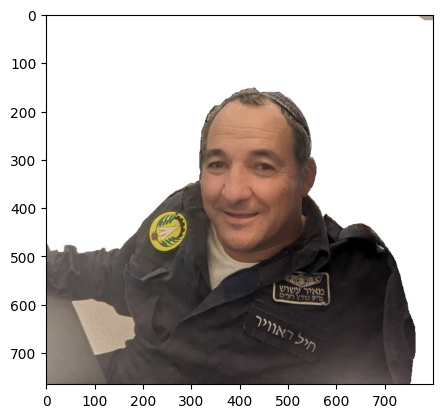

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

image_path = 'ashush_body.jpeg'
# image_path = 'C:\\Users\\bkand\\Downloads\\shilon.jpeg'
img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
h, w = img.shape; ratio = w/h
img = cv.resize(img, (int(ratio*120), 120))
plt.imshow(img)

from PIL import Image
with Image.open(image_path) as im: 
    w, h = im.size; ratio = w/h
    img = np.asarray(im)
plt.imshow(img)


In [2]:

#  Holistically-Nested Edge Detection (https://arxiv.org/abs/1504.06375) neural network
#  is used as an example model. Find a pre-trained model at https://github.com/s9xie/hed.

class CropLayer(object):
    def __init__(self, params, blobs):
        self.xstart = 0
        self.xend = 0
        self.ystart = 0
        self.yend = 0

    # Our layer receives two inputs. We need to crop the first input blob
    # to match a shape of the second one (keeping batch size and number of channels)
    def getMemoryShapes(self, inputs):
        inputShape, targetShape = inputs[0], inputs[1]
        batchSize, numChannels = inputShape[0], inputShape[1]
        height, width = targetShape[2], targetShape[3]

        self.ystart = int((inputShape[2] - targetShape[2]) / 2)
        self.xstart = int((inputShape[3] - targetShape[3]) / 2)
        self.yend = self.ystart + height
        self.xend = self.xstart + width

        return [[batchSize, numChannels, height, width]]

    def forward(self, inputs):
        return [inputs[0][:,:,self.ystart:self.yend,self.xstart:self.xend]]

prototxt = "deploy.prototxt"
caffemodel ="hed_pretrained_bsds.caffemodel"


# Load the model.
net = cv.dnn.readNetFromCaffe(prototxt, caffemodel)
cv.dnn_registerLayer('Crop', CropLayer)

image=img

inp = cv.dnn.blobFromImage(image, scalefactor=.8, size=image.shape[:2],
                           mean=(104.00698793, 116.66876762, 122.67891434),
                           swapRB=True, crop=False)
net.setInput(inp)
# edges = cv.Canny(image,image.shape[1],image.shape[0])
out = net.forward()

out = out[0, 0]
out = cv.resize(out, (image.shape[1], image.shape[0]))

out=cv.cvtColor(out,cv.COLOR_GRAY2BGR)
out = 255 * out
out = out.astype(np.uint8)

(np.float64(-0.5), np.float64(799.5), np.float64(764.5), np.float64(-0.5))

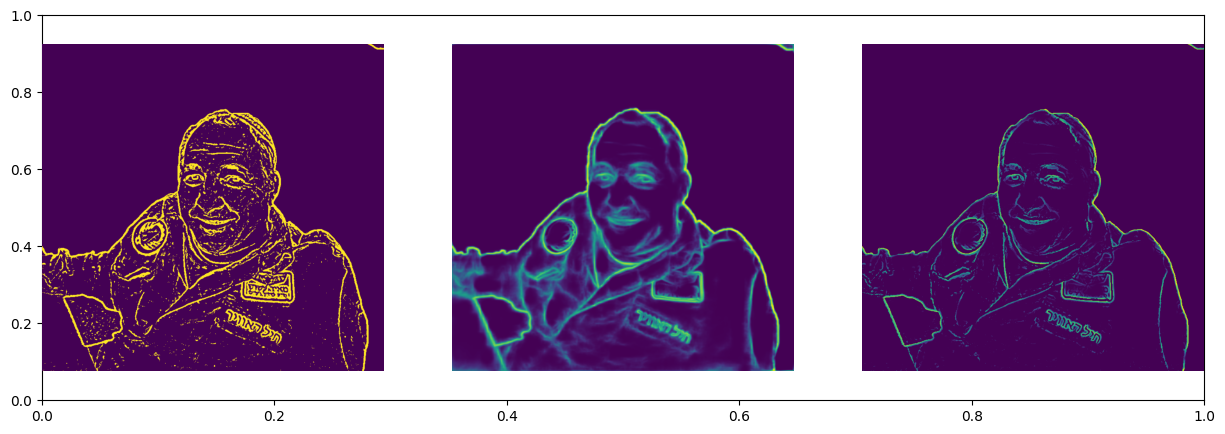

In [3]:

img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

img = cv.medianBlur(img,5)
# https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html
gray_threshold = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV,11,2)
gray_hed = cv.cvtColor( out, cv.COLOR_RGB2GRAY)
gray_bitwise_hed_and_threshold = np.bitwise_and(gray_threshold, gray_hed)
plt.subplots(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(gray_threshold)
plt.subplot(1, 3, 2)
plt.imshow(gray_hed)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(gray_bitwise_hed_and_threshold)
plt.axis('off')

Found 1750 raw contours.
Contour 192 (Area: 58.00, Simplified points: 3):
Contour 353 (Area: 50.00, Simplified points: 4):
Contour 354 (Area: 53.50, Simplified points: 4):
Contour 371 (Area: 129.00, Simplified points: 2):
Contour 384 (Area: 78.50, Simplified points: 6):
Contour 388 (Area: 994.50, Simplified points: 7):
Contour 390 (Area: 175.50, Simplified points: 6):
Contour 392 (Area: 74.50, Simplified points: 7):
Contour 393 (Area: 166.00, Simplified points: 7):
Contour 510 (Area: 1889.00, Simplified points: 4):
Contour 511 (Area: 46.00, Simplified points: 7):
Contour 514 (Area: 116.00, Simplified points: 6):
Contour 515 (Area: 207.00, Simplified points: 8):
Contour 517 (Area: 97.00, Simplified points: 7):
Contour 518 (Area: 95.50, Simplified points: 7):
Contour 519 (Area: 77.50, Simplified points: 7):
Contour 520 (Area: 118.00, Simplified points: 6):
Contour 535 (Area: 55.50, Simplified points: 6):
Contour 614 (Area: 11300.00, Simplified points: 5):
Contour 616 (Area: 9613.50, Simp

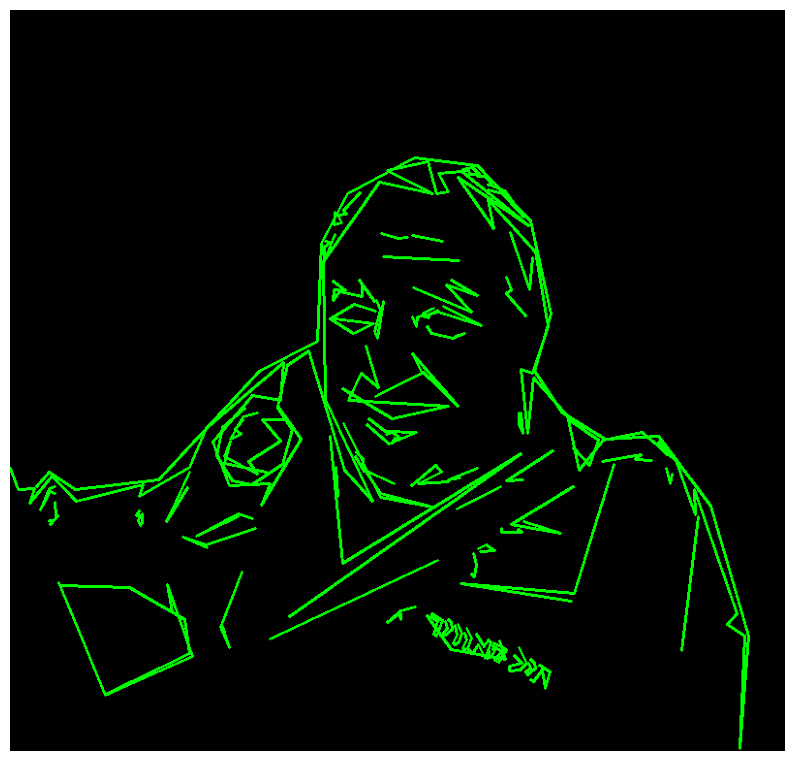

In [33]:
import cv2

# ashush
min_area_threshold = 40
epsilon_factor_lo, epsilon_factor_hi = 0.034, 0.002

# shilon
# min_area_threshold = 100
# epsilon_factor_lo, epsilon_factor_hi = 0.06, 0.003

contours, hierarchy = cv.findContours(gray_bitwise_hed_and_threshold, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
output_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8) # 3 channels for color

filtered_contours = []
vectorized_lines = []

print(f"Found {len(contours)} raw contours.")

vector_to_macro = []
for i, contour in enumerate(contours):

  # Filter out small contours which might be noise
  area = cv.contourArea(contour)
  if area < min_area_threshold:
    continue

  perimeter = cv2.arcLength(contour, True)
  # NOTE: fine tune the epsilon factor to your needs ( larger contours need more details )
  epsilon_factor = epsilon_factor_hi if contour.shape[0] > 1000 else epsilon_factor_lo
  epsilon = epsilon_factor * perimeter
  # Approximate the contour with a polygon (Ramer-Douglas-Peucker algorithm)
  approx = cv2.approxPolyDP(contour, epsilon, True)
  color = (0, 255, 0)
  
  # Store the line segments
  # Each point in 'approx' is a vertex of the simplified polygon.
  # We connect consecutive points to form line segments.
  print(f"Contour {i} (Area: {area:.2f}, Simplified points: {len(approx)}):")
  approx_lines = []
  for j in range(len(approx)):
    p1 = approx[j][0]
    p2 = approx[(j + 1) % len(approx)][0] # Connect last point to first for closed contour
    line_segment = [list(p1), list(p2)]
    vectorized_lines.append(line_segment)
    approx_lines.append(list(p1))
  vector_to_macro.append(approx_lines)
vector_to_macro = vector_to_macro[6:-1]
for lines in vector_to_macro: 
  for line in zip(lines, lines[1:]):
    p1, p2 = line
    cv.line(output_image,p1, p2,(0, 255,0),2)

plt.subplots(figsize=(10, 10))
plt.axis('off')
plt.imshow(output_image)

print('line count:', len(sum(vector_to_macro, [])))

6

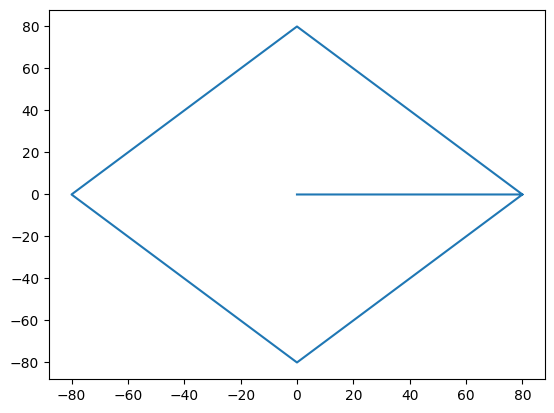

In [77]:
v = [[0, 0], [80, 0], [0, 80], [-80, 0], [0, -80], [80, 0]]
xx, yy = np.array(v)[:, 0], np.array(v)[:, 1]
plt.plot(xx, yy)
len(v)

8

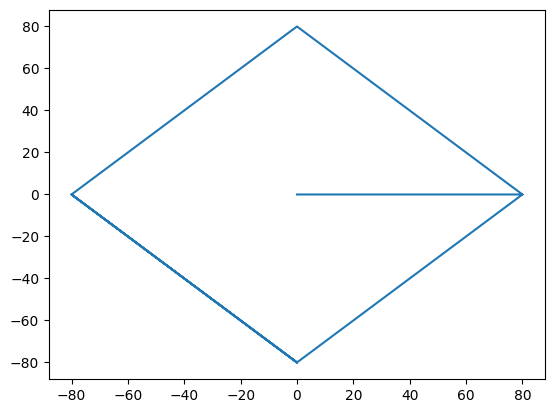

In [83]:

def crt_correction(v): 
    new_vec = []
    for i in range(len(v)): 
        if v[i][0] >= 0:  # don't change anything in the positive half of the thingy 
            new_vec.append(v[i])
            continue 

        # neg half of rect 
        x, nx = v[i][0], v[i+1][0]
        if (nx - x > 0): # from neg half to the right 
            new_vec.append(v[i])
            new_vec.append(v[i+1])
            new_vec.append(v[i])
    return new_vec

crt = crt_correction(v)
plt.plot(np.array(crt)[:, 0], np.array(crt)[:, 1])
len(crt)

In [ ]:
program = [0x803]
def defl(v): 
  return v

def vector(program, data):
  code = [
    0x9000 + len(data)-1, # cmd + xy data words
    2+len(program) # offset from the 0x9000 instruction itself (1 for the offset itself, and another 1 for the 0x803 instruction)
  ]
  deflection_corrected_data = defl(data)
  flattened_data = sum(deflection_corrected_data, [])
  centered_data = map(lambda x: int((x/800)*0x1000)-0x800, flattened_data)
  ycorrected_data = [-x if (i % 2) == 1 else x for i, x in enumerate(centered_data)]
  plt.plot(ycorrected_data[::2], ycorrected_data[1::2])

  result = code + program + ycorrected_data
  return result

for lines in vector_to_macro:
  program = vector(program, lines)
program = [0x7000] + program

for word in program: 
#   print(f'{word&0xffff:04x}')
# len(program)

926